In [ ]:
pip install pandas

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29495 sha256=72a5cb3b15ed1d0c9a46a42314011977c18f35aada4e5e4acd6233efeb4fad0a
  Stored in directory: c:\users\radioshack\appdata\local\pip\cache\wheels\5c\a1\5f\c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

pip install requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install schedule

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install ta

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   open_time      open      high       low     close       volume  \
0 2025-04-30  94256.82  95228.45  92910.00  94172.00  17661.27510   
1 2025-05-01  94172.00  97424.02  94130.43  96489.91  21380.45343   
2 2025-05-02  96489.90  97895.68  96350.00  96887.14  14905.74811   
3 2025-05-03  96887.13  96935.67  95753.01  95856.42   9723.34838   
4 2025-05-04  95856.42  96304.48  94151.38  94277.62  11036.38342   

               close_time  quote_asset_volume  number_of_trades  \
0 2025-04-30 23:59:59.999        1.664826e+09           3214149   
1 2025-05-01 23:59:59.999        2.053858e+09           2925716   
2 2025-05-02 23:59:59.999        1.446388e+09           2698263   
3 2025-05-03 23:59:59.999        9.359061e+08           1181239   
4 2025-05-04 23:59:59.999        1.053542e+09           1674726   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume ignore  
0                   8393.21620                  7.912724e+08      0  
1                  10925.87308            

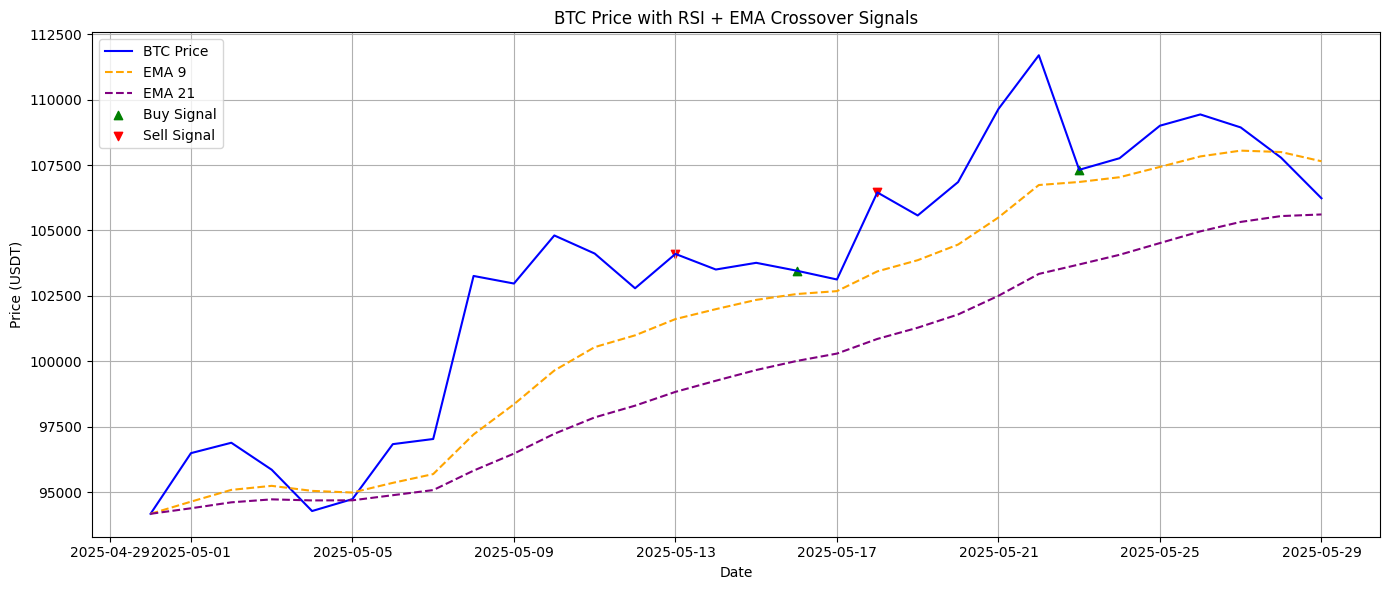

Retorno promedio: -0.05%
Retornos individuales: [-3.0, 2.89]


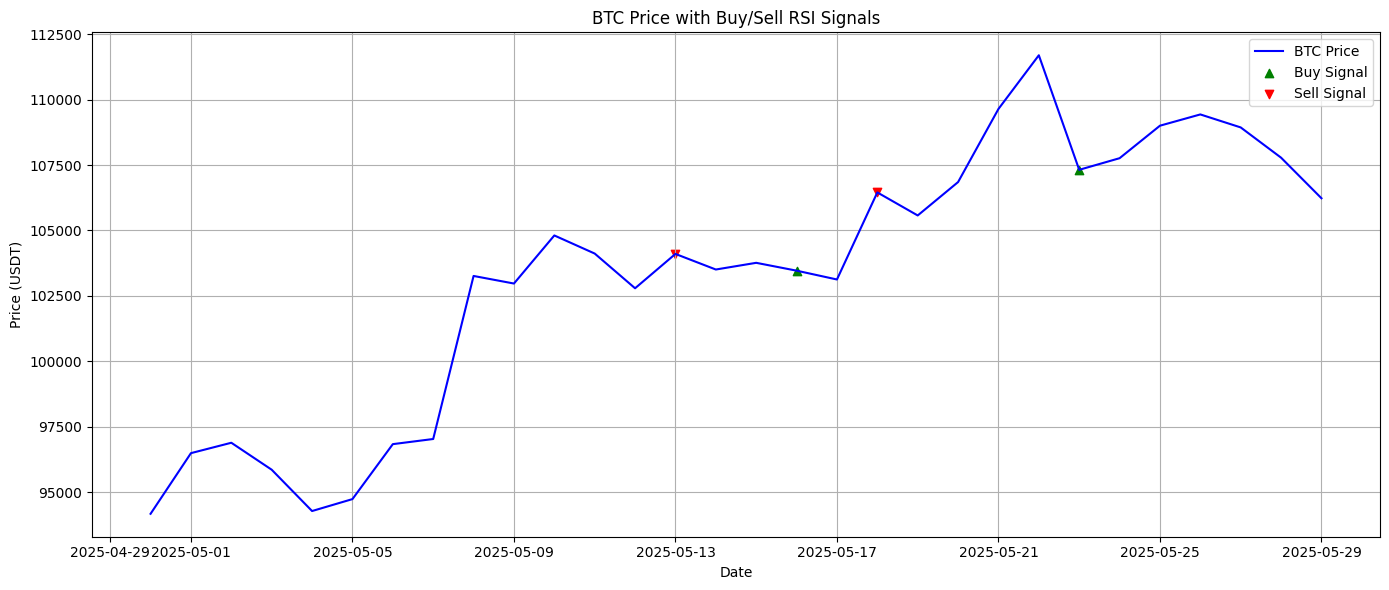

In [ ]:
#Import libraries
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import ta
#ETL PROCESS:
#EXTRACT DATA FROM REST API  

def get_binance_market_data(symbol='BTCUSDT', interval='1d', limit=30):
    url = "https://api.binance.com/api/v3/klines"
    params = {'symbol': symbol,
              'interval': interval,
              'limit': limit      
    }
    response = requests.get(url,params=params)
    data = response.json()
    return data
data = get_binance_market_data()
#I used "print(data)" to verify with oficial documentation for REST API RESPONSE to assign columns

#TRANSFORM DATA to DATAFRAME by cleaning and formating

columns = ['open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_asset_volume', 'number_of_trades',
    'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
]
df = pd.DataFrame (data, columns=columns)

#setting time format 

df['open_time'] = pd.to_datetime(df['open_time'],unit='ms')
df ['close_time'] = pd.to_datetime(df['close_time'],unit='ms')
numeric_columns = ['open', 'high', 'low', 'close', 'volume','quote_asset_volume','taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'
]
df[numeric_columns] = df[numeric_columns].astype(float)
#print(df.dtypes) verifying data types

print(df.head())

df['rsi']= ta.momentum.RSIIndicator(close=df['close'],window=14).rsi()
print(df[['close','rsi']].tail())

# ESTUDIAR DESPUÉS SOBRE EMAs
# EMA calculation
df['ema_fast'] = df['close'].ewm(span=9, adjust=False).mean()
df['ema_slow'] = df['close'].ewm(span=21, adjust=False).mean()

# EMAs Cross signal 
df['ema_signal'] = 0
df.loc[df['ema_fast'] > df['ema_slow'], 'ema_signal'] = 1
df.loc[df['ema_fast'] < df['ema_slow'], 'ema_signal'] = -1

# MACD signal

from ta.trend import MACD
macd = MACD(close=df['close'], window_slow=26, window_fast=12, window_sign=9)
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()

# Combined signals RSI+EMA 
df['signal'] = 0
df.loc[(df['rsi'] < 30) & (df['ema_signal'] == 1), 'signal'] = 1   # BUY
df.loc[(df['rsi'] > 70) & (df['ema_signal'] == -1), 'signal'] = -1 # SELL

# Diferencia para detectar cambios de señal (no repetir)
df['signal'] = df['signal'].diff().fillna(0)

# Assigning signals

df['signal'] = 0
df.loc[df['rsi']<30,'signal'] = 1 # 1 = "BUY"
df.loc[df['rsi']>70,'signal'] = -1 # -1 = "SELL"
df['signal'] = df['signal'].diff().fillna(0)
#print(df['signal'])

# Calcular ganancias entre señales de compra (1) y venta (-1)
entries = []
exits = []
returns = []

for i in range(1, len(df)):
    if df['signal'].iloc[i] == 1:
        entry_price = df['close'].iloc[i]
        entry_time = df['open_time'].iloc[i]
    elif df['signal'].iloc[i] == -1 and 'entry_price' in locals():
        exit_price = df['close'].iloc[i]
        exit_time = df['open_time'].iloc[i]
        gain_pct = (exit_price - entry_price) / entry_price * 100

        entries.append((entry_time, entry_price))
        exits.append((exit_time, exit_price))
        returns.append(gain_pct)

        del entry_price  # Reset para evitar mal uso

# Mostrar resumen de retornos
if returns:
    #Convertir floats a python nativo
    returns = [float(r) for r in returns]

    avg_return = sum(returns) / len(returns)
    print(f"Número de operaciones: {len(returns)}")
    
    #Grafica de EMA junto con el precio
    plt.figure(figsize=(14,6))
    plt.plot(df['open_time'], df['close'], label='BTC Price', color='blue')
    plt.plot(df['open_time'], df['ema_fast'], label='EMA 9', color='orange', linestyle='--')
    plt.plot(df['open_time'], df['ema_slow'], label='EMA 21', color='purple', linestyle='--')
    plt.scatter(df[df['signal'] == 1]['open_time'], df[df['signal'] == 1]['close'], label='Buy Signal', marker='^', color='green')
    plt.scatter(df[df['signal'] == -1]['open_time'], df[df['signal'] == -1]['close'], label='Sell Signal', marker='v', color='red')
    plt.title('BTC Price with RSI + EMA Crossover Signals')
    plt.xlabel('Date')
    plt.ylabel('Price (USDT)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    print(f"Retorno promedio: {avg_return:.2f}%")
    print(f"Retornos individuales: {[round(r, 2) for r in returns]}")
else:
    print("No se encontraron pares completos de compra/venta para calcular retorno.")

plt.figure(figsize=(14,6))
plt.plot(df['open_time'], df['close'], label='BTC Price', color='blue')
plt.scatter(df[df['signal'] == 1]['open_time'], df[df['signal'] == 1]['close'], label='Buy Signal', marker='^', color='green')
plt.scatter(df[df['signal'] == -1]['open_time'], df[df['signal'] == -1]['close'], label='Sell Signal', marker='v', color='red')
plt.title('BTC Price with Buy/Sell RSI Signals')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



